<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/aprendizaje_refuerzos/TicTacToe_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small>Diplomatura en Ciencia de Datos y sus Aplicaciones - FaMAF - UNC - 2021</small>
# Aprendizaje por Refuerzos

Integrantes:
- Bosch, Daniela
- Gherra, Estefanía
- Primo, Eugenia
- Rajchenberg, Natan

## Introducción

En este trabajo realizamos el entrenamiento de un jugador de TaTeTi utilizando distintos modelos variando hiperparámetros y recompensas en el entorno. Además se probó complejizar el entorno agregando reglas al juego y aumentando el tablero para observar distintos resultados en el aprendizaje.

### Instalaciones

In [ ]:
!pip install stable-baselines3[extra,tests,docs]

In [ ]:
#@title Instalación de RLBaselinesZoo (no modificar)

# Estamos en Colab?

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo
    !cd rl-baselines3-zoo/
    !apt-get install swig cmake ffmpeg
    !pip install -r /content/rl-baselines3-zoo/requirements.txt

In [3]:
import os
from subprocess import Popen, PIPE

import numpy as np
import matplotlib.pyplot as plt
import random

import gym
from gym import spaces
from gym.spaces import Discrete, Box


from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env

Definimos las funciones auxiliares para el análisis de los resultados.

In [4]:
def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()

In [5]:
def calculate_results(model, env):
    victorias = 0
    empates = 0
    derrotas = 0

    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        if dones:
            if info[0]['resultado'] == 'Victoria':
                victorias += 1
            if info[0]['resultado'] == 'Empate':
                empates += 1
            if info[0]['resultado'] == 'Derrota':
                derrotas += 1
    print('Victorias = ', victorias/(victorias+empates+derrotas))     
    print('Empates = ', empates/(victorias+empates+derrotas))     
    print('Derrotas = ', derrotas/(victorias+empates+derrotas))        

In [6]:
def print_game(model, env):
    obs = env.reset()
    for i in range(100):
        action, _states = model.predict(obs)
        print(action)
        obs, rewards, dones, info = env.step(action)
        env.render(mode='console')
        if dones:
            obs = env.reset()
            print(info[0]['resultado'], 'mediante action=', action)
            print("-*-*-*-*-*-*-*-*-*-*-*-*-")
        else:
            print("-------")

## Modelo 1: Entrenamiento de jugador de Ta Te Tí con entorno simple y política PPO.

Se realiza la implementación de un Custom Environment para aprender a jugar Ta Te Tí.
El trabajo toma la estructura, y la función de renderizado (render) de https://github.com/francofgp/Tic-Tac-Toe-Gym

Sin embargo se ha modificado completamente las funciones __init__ y step. Además se ha programado un oponente con cierta inteligencia contra el que juega nuestro robot, de modo de conseguir una IA mejor.

En esta implementación, hemos probado con un action_space que se recalcula según el estado del juego (el número de acciones es variable según avanza la partida).

Tras 250.000 iteraciones, nuestro robot alcanza un reward que implica que está en una relación ganar/empatar de 65/35. Esto se chequea al final con el modelo terminado, aprovechando el diccionario `info` del environment.


In [7]:
class TicTacToe(gym.Env):
  """
  Ambiente personalizado que sigue la interfaz de gym.
  Es un entorno simple en el cuál el agente debe aprender ganarle a un adversario simple
  """
  metadata = {'render.modes': ['console']}

  def __init__(self, grid_size=10):
    super(TicTacToe, self).__init__()
        
    self.observation_space = Box(low=np.zeros(9), high=np.full((9, ), 3))
    self.state = [0,0,0,0,0,0,0,0,0]
    self.win_combs = [[0,1,2],[3,4,5],[6,7,8], #filas
                        [0,3,6],[1,4,7],[2,5,8], #cols
                        [0,4,8],[2,4,6]] #diags
    self.accum_reward = []
  
  def step(self, action):
    reward = 0
    pos = 0
    zpos = 0
    info = {}
    #Un valor de action=3 implica poner una Cruz en el tercer lugar vacío (No en el 3er lugar de la grilla, sino el 3ero de los vacíos)
    #Esto se ha planteado así para poder aprovechar la función Discrete, teniendo en cuenta que el espacio de acciones varía step a step.
    for st in self.state: 
      if st == 0:
        if zpos == action:
          self.state[pos] = 1
        zpos += 1
      pos += 1  
    if self.check_win():
      reward += 1000
      done = True
      info['resultado'] = 'Victoria'
    elif self.check_draw():
      reward = reward -100
      done=True
      info['resultado'] = 'Empate'
    else:
      self.player2() #Función con IA del adversario
      if self.check_lose():
        reward -= 1000
        done = True
        info['resultado'] = 'Derrota'
      elif self.check_draw():
        reward = reward -100
        done=True
        info['resultado'] = 'Empate'
      else:
        done = False  
    
    self.accum_reward.append(reward)
    return np.array([self.state]).astype(np.float32), reward, done, info
    


  def player2(self):
    '''Si puede tapar una línea del player 1 la tapa, luego si puede generar una línea la genera, si no, juega random '''
    p2_played = False
    if self.state.count(0) > 0:
      for comb in self.win_combs:
        for skip in [0,1,2]:
          if self.state[comb[skip]]==0 and self.state[comb[[X for X in [0,1,2] if X != skip][0]]]==1 and self.state[comb[[X for X in [0,1,2] if X != skip][1]]]==1:   
            self.state[comb[skip]]=2           
            p2_played = True
            break
        else:
          continue
        break
      
      if not p2_played:
        for comb in self.win_combs:
          for skip in [0,1,2]:
            if self.state[comb[skip]]==0 and self.state[comb[[X for X in [0,1,2] if X != skip][0]]]==2 and self.state[comb[[X for X in [0,1,2] if X != skip][1]]]==2:   
              self.state[comb[skip]]=2           
              p2_played = True
              break
          else:
            continue
          break
        
      if not p2_played:
        random_action = random.randint(0,self.state.count(0)-1)
        pos = 0
        zpos = 0
        for st in self.state:
          if st == 0:
            if zpos == random_action:
              self.state[pos] = 2
            zpos += 1
          pos += 1  
  
  def check_win(self):
    for comb in self.win_combs:
      if self.state[comb[0]]==1 and self.state[comb[1]]==1 and self.state[comb[2]]==1:
        return True
    return False

  def check_lose(self):
    for comb in self.win_combs:
      if self.state[comb[0]]==2 and self.state[comb[1]]==2 and self.state[comb[2]]==2:
        return True
    return False
    
  def check_draw(self):
    if self.state.count(0) > 0:
      return False
    else:
      return True
  
  def reset(self):
    self.state=[0,0,0,0,0,0,0,0,0]
    self.accum_reward = []
    return np.array([self.state]).astype(np.float32)

  def render(self, mode='console'):
    if mode != 'console':
      raise NotImplementedError()
    # en nuestra interfaz de consola, representamos el agente como una cruz, y 
    # el resto como un punto
    draw = ["-", "X", "O"]
    drawing = [draw[st] for st in self.state]
    for i in range(0,9,3):
      if i==0:
        print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} ")
      if i==3:
        print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} ")
      if i==6:
        print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} ")
  def close(self):
    pass

  @property
  def action_space(self):
    return Discrete(self.state.count(0))

Ahora entrenamos al jugador con un entorno preentrenado.

In [8]:
ttt1 = TicTacToe()
env = make_vec_env(lambda: ttt1, n_envs=1, seed=22)
model = PPO('MlpPolicy', env).learn(250_000)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Guardamos el modelo para no volver a entrenar localmente.

In [9]:
model.save("TicTacToe")

### Resultados modelo 1
Porcentaje de victorias y empates:

In [10]:
calculate_results(model, env)

Victorias =  0.6298076923076923
Empates =  0.3605769230769231
Derrotas =  0.009615384615384616


Se imprime a continuación un ejemplo del robot jugando unas 20/25 partidas.
En cada step se observa al inicio la acción tomada por el robot (recordar que la acción señala la posición del lugar, sólo contando a los lugares vacíos de la grilla 3x3).

Luego se dibuja la grilla, en la que se marca con una X al robot, y con un O al adversario. En cada step se agregan los 2 movimientos.

Luego se marca, si en ese movimiento se ha terminado, el resultado de la partida para nuestro robot.



In [11]:
print_game(model, env)

[0]
X O - 
- - - 
- - - 
-------
[0]
X O X 
- - O 
- - - 
-------
[0]
X O X 
X - O 
O - - 
-------
[0]
X O X 
X X O 
O - O 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - O 
- - - 
-------
[0]
X X O 
- - O 
- - - 
-------
[0]
X X O 
X - O 
O - - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X O - 
- - - 
- - - 
-------
[0]
X O X 
O - - 
- - - 
-------
[0]
X O X 
O X - 
- - O 
-------
[1]
- - - 
- - - 
- - - 
Victoria mediante action= [1]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - - 
O - - 
-------
[1]
X O X 
- - - 
O - - 
-------
[0]
X O X 
X O - 
O - - 
-------
[0]
X O X 
X O X 
O - O 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
O - - 
- - - 
-------
[1]
X O X 
O - - 
- - - 
-------
[0]
X O X 
O X - 
- - O 
-------
[1]
- - - 
- - - 
- - - 
Victoria mediante action= [1]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X

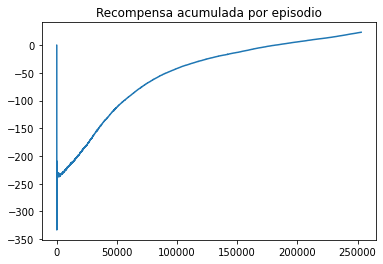

In [12]:
plot_reward_per_episode(ttt1.accum_reward)

Con este modelo el robot gana un 60% de los partidos y un 35% empata aproximadamente. Se observan pocas derrotas.

In [17]:
ttt1.reset()
env.reset()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Modelo 2: Entrenamiento de jugador de Ta Te Tí basado en modelo 1 con cambio de hiperparámetros.

Ahora vemos de entrenar este mismo modelo modificando algunos hiperparámetros.

Learning rate: 0.0008, gamma: 0.8


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Victorias =  0.319047619047619
Empates =  0.6761904761904762
Derrotas =  0.004761904761904762


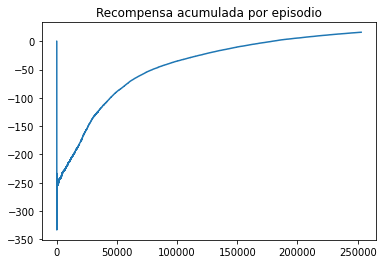

------------------------------------------

Learning rate: 0.0008, gamma: 0.98
Victorias =  0.5679611650485437
Empates =  0.4320388349514563
Derrotas =  0.0


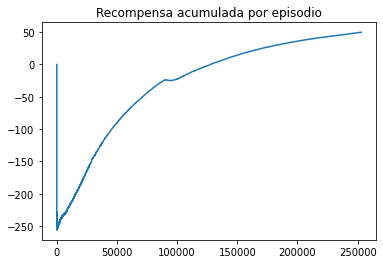

------------------------------------------

Learning rate: 0.0001, gamma: 0.8
Victorias =  0.3463414634146341
Empates =  0.5707317073170731
Derrotas =  0.08292682926829269


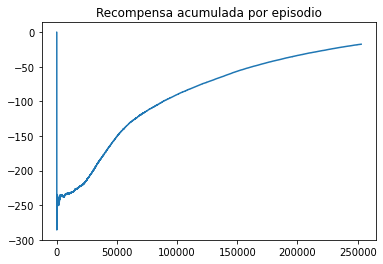

------------------------------------------

Learning rate: 0.0001, gamma: 0.98
Victorias =  0.35784313725490197
Empates =  0.5735294117647058
Derrotas =  0.06862745098039216


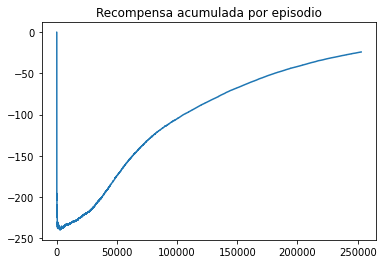

------------------------------------------



In [79]:
learning_rates = [0.0008, 0.0001]
gammas = [0.8, 0.98]
for learning_rate in learning_rates:
    for gamma in gammas:
        print(f"Learning rate: {learning_rate}, gamma: {gamma}")
        ttt1 = TicTacToe()
        env = make_vec_env(lambda: ttt1, n_envs=1, seed=22)
        model = PPO('MlpPolicy', env, learning_rate=learning_rate, gamma=gamma).learn(250_000)

        calculate_results(model, env)
        plot_reward_per_episode(ttt1.accum_reward)

        print("------------------------------------------\n")
        ttt1.reset()
        env.reset()

- Vemos que un `gamma` más grande mejora un poco los resultados.
- El `learning_rate` no mejora el baseline.

## Modelo 3: Entrenamiento de jugador de Ta Te Tí con entorno en el que se mejora la recompensa.

Ahora realizamos modificaciones sobre la recompensa. Anteriormente la misma se obtenía al final del juego de acuerdo al resultado obtenido. Agregamos recompensas tanto positivas como negativas para cada turno, en donde uno de los casos resulta poco conveniente (las decisiones no ayudan a ganar) y en el otro caso se intenta mejorar el entrenamiento.

Para esto creamos un wrapper sobre la clase TicTacToe original con nuevas propiedades y métodos.

In [58]:
class TicTacToe2(TicTacToe):
    """
    Ambiente personalizado que sigue la interfaz de gym.
    Es un entorno con recompensas por turnos.
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, grid_size=10, reward_same_line=0, penalty_not_same_line=0,
                 reward_around=0, penalty_not_around=0, reward_win=1000, 
                 penalty_lose=1000, penalty_draw=100, disabled_position=-1):
        super(TicTacToe, self).__init__()

        self.observation_space = Box(low=np.zeros(9), high=np.full((9, ), 3))
        self.state = [
            0,0,0,
            0,0,0,
            0,0,0,
        ]
        self.win_combs = [
            [0,1,2],[3,4,5],[6,7,8], # filas
            [0,3,6],[1,4,7],[2,5,8], # cols
            [0,4,8],[2,4,6] # diags
        ] 
        self.accum_reward = []

        self.disabled_position = disabled_position
        self.is_first_move = True

        # Recompensas
        self.reward_same_line = reward_same_line
        self.penalty_not_same_line = penalty_not_same_line
        self.reward_around = reward_around
        self.penalty_not_around = penalty_not_around
        self.reward_win = reward_win 
        self.penalty_lose = penalty_lose
        self.penalty_draw = penalty_draw

    def step(self, action):
        reward = 0
        pos = 0
        zpos = 0
        info = {}
        # Un valor de action=3 implica poner una Cruz en el tercer lugar vacío 
        # (No en el 3er lugar de la grilla, sino el 3ero de los vacíos)
        # Esto se ha planteado así para poder aprovechar la función Discrete, 
        # teniendo en cuenta que el espacio de acciones varía step a step.
        for st in self.state: 
            if st == 0:
                if zpos == action:
                    self.state[pos] = 1
                zpos += 1
            position = pos
            pos += 1  

        if self.disabled_position != -1:
            if self.check_disable_first_move(position):
                reward -= 500
        self.is_first_move = False

        if self.check_around(position):
            reward += self.reward_around
        else:
            reward -= self.penalty_not_around

        if self.check_same_line(position):
            reward += self.reward_same_line
        else:
            reward -= self.penalty_not_same_line

        if self.check_win():
            reward += self.reward_win
            done = True
            info['resultado'] = 'Victoria'
        elif self.check_draw():
            reward = reward - self.penalty_draw
            done=True
            info['resultado'] = 'Empate'
        else:
            self.player2() #Función con IA del adversario
            if self.check_lose():
                reward -= self.penalty_lose
                done = True
                info['resultado'] = 'Derrota'
            elif self.check_draw():
                reward = reward - self.penalty_draw
                done=True
                info['resultado'] = 'Empate'
            else:
                done = False  
        self.accum_reward.append(reward)
        return np.array([self.state]).astype(np.float32), reward, done, info

    def check_around(self, pos):
        """Verifica si la posición se encuentra alrededor de una X.
        Esto puede llevar a una desventaja en el juego.
        """
        if pos not in [0,3,6] and self.state[pos-1] == 1:
            return True
        elif pos not in [2,5,8] and self.state[pos+1] == 1:
            return True
        elif pos not in [0,1,2] and self.state[pos-3] == 1:
            return True
        elif pos not in [6,7,8] and self.state[pos+3] == 1:
            return True
        else:
            return False
    
    def check_same_line(self, pos):
        """Verifica si la posición se encuentra en la misma línea que una X.
        Verifica además si no existe un O en esa misma línea (valor 2).
        Esto puede llevar a una ventaja en el juego.
        """
        combs = [(1,0), (0,1), (1,1)]
        def check_state(pos1, pos2):
            return (self.state[pos1], self.state[pos2]) in combs

        # Horizontal
        if pos in [0,3,6] and check_state(pos+1, pos+2):
            return True
        elif pos in [1,4,7] and check_state(pos-1, pos+1):
            return True
        elif pos in [2,5,8] and check_state(pos-2, pos-1):
            return True
        # Vertical
        elif pos in [0,1,2] and check_state(pos+3, pos+6):
            return True
        elif pos in [3,4,5] and check_state(pos-3, pos+3):
            return True
        elif pos in [6,7,8] and check_state(pos-6, pos-3):
            return True
        # Diagonal
        elif pos == 0 and check_state(4, 8):
            return True
        elif pos == 4 and (check_state(0, 8) or check_state(2, 6)):
            return True
        elif pos == 8 and check_state(0, 4):
            return True
        elif pos == 2 and check_state(4, 6):
            return True
        elif pos == 6 and check_state(2, 4):
            return True
        else:
            return False

    def check_disable_first_move(self, pos):
        if pos == self.disabled_position and self.is_first_move:   
            return True
        else:
            return False

    def reset(self):
        self.state = [
            0,0,0,
            0,0,0,
            0,0,0
        ]
        return np.array([self.state]).astype(np.float32)

Entrenamos el jugador que obtiene recompensas al ubicar la ficha alrededor de una anterior. Creemos que el juego empeora, veamos si es cierto.

In [41]:
ttt2 = TicTacToe2(reward_around=500, penalty_not_around=100)
env = make_vec_env(lambda: ttt2, n_envs=1, seed=22)
model = PPO('MlpPolicy', env).learn(250_000)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Resultados modelo 3a

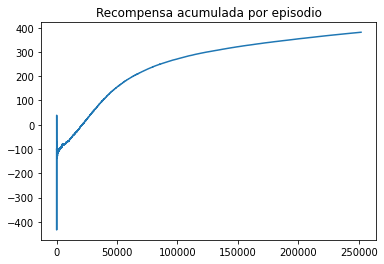

In [43]:
plot_reward_per_episode(ttt2.accum_reward)

In [44]:
calculate_results(model, env)

Victorias =  0.22429906542056074
Empates =  0.6214953271028038
Derrotas =  0.1542056074766355


In [45]:
print_game(model, env)

[5]
- - - 
- - X 
- O - 
-------
[4]
- - - 
O X X 
- O - 
-------
[0]
X - - 
O X X 
- O O 
-------
[0]
X X O 
O X X 
- O O 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[7]
- O - 
- - - 
- X - 
-------
[0]
X O O 
- - - 
- X - 
-------
[0]
X O O 
X - - 
O X - 
-------
[0]
X O O 
X X O 
O X - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[7]
- - - 
O - - 
- X - 
-------
[0]
X - O 
O - - 
- X - 
-------
[0]
X X O 
O O - 
- X - 
-------
[0]
- - - 
- - - 
- - - 
Derrota mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[7]
- - - 
- O - 
- X - 
-------
[5]
- - - 
- O - 
X X O 
-------
[0]
X - - 
O O - 
X X O 
-------
[0]
X X O 
O O - 
X X O 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[7]
- - - 
- - O 
- X - 
-------
[3]
- O - 
X - O 
- X - 
-------
[0]
X O - 
X - O 
O X - 
-------
[0]
X O X 
X O O 
O X - 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-

Vemos que la victoria baja debido a que la recompensa asignada no es la correcta. Pretendimos asignar una recompensa acumulativa, que sumara 500 si en el paso siguiente el robot colocaba una ficha alrededor de la posición actual. Sin embargo, al ver que la cantidad de victorias disminuyó respecto al entorno anterior, dedujimos que para logar que hiciera Ta-Te-Ti tendríamos que haberle dado recompensa al colocar una tercer ficha alineada con las fichas anteriores que ya se encontraban de esta manera.

In [47]:
ttt2.reset()
env.reset()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Ahora probamos asignar correctamente las recompensas cuando el jugador pone una ficha en la misma línea que una anterior y además no hay una ficha del otro jugador.

In [53]:
ttt3 = TicTacToe2(reward_same_line=50, penalty_not_same_line=1)
env = make_vec_env(lambda: ttt3, n_envs=1, seed=22)
model = PPO('MlpPolicy', env).learn(250_000)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Resultados modelo 3b

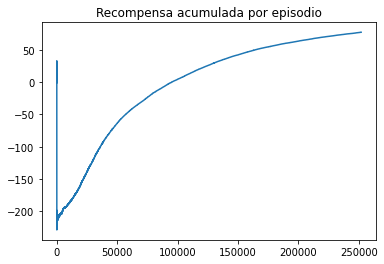

In [54]:
plot_reward_per_episode(ttt3.accum_reward)

In [55]:
calculate_results(model, env)

Victorias =  0.41904761904761906
Empates =  0.5095238095238095
Derrotas =  0.07142857142857142


In [56]:
print_game(model, env)

[0]
X O - 
- - - 
- - - 
-------
[0]
X O X 
- - - 
- O - 
-------
[0]
X O X 
X - - 
O O - 
-------
[0]
X O X 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - O 
- - - 
-------
[0]
X X O 
- - O 
- - - 
-------
[0]
X X O 
X - O 
O - - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - O 
- - - 
-------
[0]
X X O 
- - O 
- - - 
-------
[0]
X X O 
X - O 
O - - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- O - 
- - - 
-------
[1]
X O X 
- O - 
- - - 
-------
[0]
X O X 
X O - 
O - - 
-------
[0]
X O X 
X O X 
O - O 
-------
[0]
- - - 
- - - 
- - - 
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - - 
- - O 
-------
[1]
X O X 
- - - 
- - O 
-------
[0]
X O X 
X - - 
O - O 
-------
[0]
X O X 
X X O 
O - O 
-------
[0]
- - - 
- - - 


Vemos que los resultados mejoran respecto al entrenamiento anterior pero no mejora respecto del entrenamiento baseline con recompensas sobre el final de la partida. Puede deberse a que la regla además de verificar si se encuentra en la misma línea libre del oponente, debería verificar también que no existan fichas en otras líneas (debe armar sólo una combinación). Es decir, el jugador se "distrae" armando otras combinaciones.

Otra razón es que quizás la estrategia no solamente se base en ubicar la ficha en la misma línea sino también ubicarlos de cierta manera que pueda "engañar" al rival sobre futuros movimientos. 

In [52]:
ttt3.reset()
env.reset()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Modelo 4: Entrenamiento de jugador de Ta Te Tí con modificaciones en las reglas de juego.

En este modelo se penaliza al jugador si su jugada comienza la partida en la posición central.

In [65]:
ttt4 = TicTacToe2(disabled_position=4)
env = make_vec_env(lambda: ttt4, n_envs=1, seed=22)
model = PPO('MlpPolicy', env).learn(250_000)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Resultados modelo 4

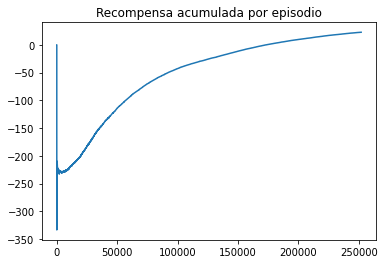

In [66]:
plot_reward_per_episode(ttt4.accum_reward)

In [67]:
calculate_results(model, env)

Victorias =  0.425
Empates =  0.56
Derrotas =  0.015


In [64]:
print_game(model, env)

[0]
X - O 
- - - 
- - - 
-------
[1]
X - O 
X - - 
O - - 
-------
[1]
X - O 
X X O 
O - - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
O - - 
- - - 
-------
[1]
X O X 
O - - 
- - - 
-------
[0]
X O X 
O X - 
- - O 
-------
[1]
- - - 
- - - 
- - - 
Victoria mediante action= [1]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
O - - 
- - - 
-------
[1]
X O X 
O - - 
- - - 
-------
[0]
X O X 
O X - 
- - O 
-------
[1]
- - - 
- - - 
- - - 
Victoria mediante action= [1]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - - 
- - - 
- O - 
-------
[0]
X X O 
- - - 
- O - 
-------
[0]
X X O 
X - - 
O O - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[0]
X - O 
- - - 
- - - 
-------
[1]
X - O 
X - - 
O - - 
-------
[1]
X - O 
X X O 
O - - 
-------
[0]
X X O 
X X O 
O O - 
-------
[0]
- - - 
- - - 
- - - 
Victoria mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[

- Vemos que los resultados son bastante malos debido a que la posición central es bastante estratégica para ganar, y la regla impuesta penaliza al jugador al ubicarse allí en el primer turno.

In [68]:
ttt4.reset()
env.reset()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Modelo 5: Entrenamiento de jugador de Ta Te Tí con entorno complejo de 4x4.

En este entorno más complejo, el jugador debe hacer combinaciones de 4 X en una misma línea para ganar. Las recompensas utilizadas son las baseline con valores que se actualizan únicamente al finalizar la partida. Hacemos además que el jugador 2 juegue de manera aleatoria.

In [70]:
class TicTacToeAdvanced(TicTacToe):
    """
    Ambiente personalizado que sigue la interfaz de gym.
    Es un entorno más complejo en el cuál el agente debe aprender ganarle a un adversario simple
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, grid_size=10):
        super(TicTacToe, self).__init__()
    
        self.observation_space = Box(low=np.zeros(16), high=np.full((16, ), 4))
        self.state = [
            0,0,0,0,
            0,0,0,0,
            0,0,0,0,
            0,0,0,0
        ]
        self.win_combs = [
            [0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15], # filas
            [0,4,8,12],[1,5,9,13],[2,6,10,14], [3,7,11,15], # cols
            [0,5,10,15],[3,6,9,12] # diags
        ]
        self.accum_reward = []

    def check_win(self):
        for comb in self.win_combs:
            if self.state[comb[0]] == 1 and self.state[comb[1]] == 1 \
                and self.state[comb[2]] == 1 and self.state[comb[3]] == 1:
                return True
        return False 

 
    def check_lose(self):
        for comb in self.win_combs:
            if self.state[comb[0]] == 2 and self.state[comb[1]] == 2 \
                and self.state[comb[2]] == 2 and self.state[comb[3]] == 2:
                return True
        return False 

    def reset(self):
        self.state = [
            0,0,0,0,
            0,0,0,0,
            0,0,0,0,
            0,0,0,0
        ]

        return np.array([self.state]).astype(np.float32)
  
    def player2(self):
        """El jugador juega de manera aleatoria"""
        if self.state.count(0) > 0:
            random_action = random.randint(0,self.state.count(0)-1)
            pos = 0
            zpos = 0
            for st in self.state:
                if st == 0:
                    if zpos == random_action:
                        self.state[pos] = 2
                    zpos += 1
                pos += 1  
  
    def render(self, mode='console'):
        if mode != 'console':
            raise NotImplementedError()
        # en nuestra interfaz de consola, representamos el agente como una cruz, y 
        # el resto como un punto
        draw = ["-", "X", "O"]
        drawing = [draw[st] for st in self.state]
        for i in range(0,16,4):
            if i == 0:
                print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} {drawing[i+3]}")
            if i == 4:
                print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} {drawing[i+3]}")
            if i == 8:
                print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} {drawing[i+3]}")
            if i == 12:
                print(f"{drawing[i]} {drawing[i+1]} {drawing[i+2]} {drawing[i+3]}")

In [71]:
ttt5 = TicTacToeAdvanced()
env = make_vec_env(lambda: ttt5, n_envs=1, seed=22)
model = PPO('MlpPolicy', env).learn(250_000)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Resultados modelo 5

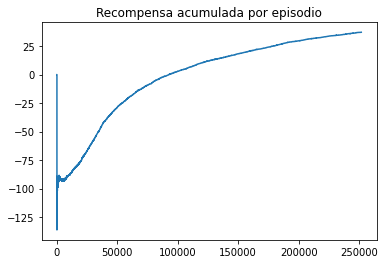

In [72]:
plot_reward_per_episode(ttt5.accum_reward)

In [73]:
calculate_results(model, env)

Victorias =  0.6140350877192983
Empates =  0.09941520467836257
Derrotas =  0.28654970760233917


In [74]:
print_game(model, env)

[0]
X - - -
- O - -
- - - -
- - - -
-------
[0]
X X - O
- O - -
- - - -
- - - -
-------
[0]
X X X O
- O - -
- - - O
- - - -
-------
[0]
X X X O
X O O -
- - - O
- - - -
-------
[0]
X X X O
X O O X
O - - O
- - - -
-------
[0]
X X X O
X O O X
O X - O
O - - -
-------
[0]
X X X O
X O O X
O X X O
O O - -
-------
[0]
- - - -
- - - -
- - - -
- - - -
Empate mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[12]
- - - -
- - - -
O - - -
X - - -
-------
[0]
X - - -
- - - -
O - - -
X O - -
-------
[0]
X X - -
O - - -
O - - -
X O - -
-------
[0]
X X X O
O - - -
O - - -
X O - -
-------
[0]
X X X O
O X - -
O - - -
X O - O
-------
[0]
X X X O
O X X O
O - - -
X O - O
-------
[0]
- - - -
- - - -
- - - -
- - - -
Derrota mediante action= [0]
-*-*-*-*-*-*-*-*-*-*-*-*-
[7]
- O - -
- - - X
- - - -
- - - -
-------
[1]
- O X -
- - - X
- - - -
- O - -
-------
[0]
X O X -
O - - X
- - - -
- O - -
-------
[0]
X O X X
O - - X
O - - -
- O - -
-------
[0]
X O X X
O X O X
O - - -
- O - -
-------
[0]
X O X X
O X O X
O X - 

Vemos que este entorno resulta bastante más complicado de entrenar. No se obtienen victorias tan fácilmente. Se deberían mejorar considerablemente las recompensas por etapa para que el jugador converja a buenos resultados más rápidamente.

In [ ]:
ttt5.reset()
env.reset()

## Conclusiones

Vemos la importancia de definir correctamente las recompensas sobre las acciones. Las reglas definidas no mejoraron los resultados aún variando los valores. Es posible que las mismas no sean las mejores para ganar la partida.

Vemos también que modificando algunos hiperparámetros se logra una convergencia más rápida para algunos casos.

También debemos tener en cuenta la cantidad de iteraciones puede mejorar bastante el resultado con el trade-off del costo computacional.